# Classification with GMM for CM of exoplanetary systems. 

## 1. Read and clean the file from exoplanet.eu
List of planets from exoplanet.eu, it is taking mass (and its uncertaintly), semi_major (and its uncertaintly), Metallicity (and its uncertaintly).  

It is necessary processing the data with the prurpose to obtain the Center of Mass CM, `data` is a DataFrame without the NaN values in the columns of _mass_ and _semi major axis_, and their uncertainties. Finally, we get the data cleaned.

**Remember**: `pd.notnull("name_of_column")` deletes the NaN values in the column. 

**Remember**: `data=data[['column_a','column_b',..,'column_n',]]` to get a new order in the DataFrame

In [1]:
import pandas as pd; import numpy as np
from scipy.stats import norm # normal distribution
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt 
import seaborn as sb
%matplotlib inline

# Read data (only mass and semi major axis with their uncertainties): 
data_ep = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                      usecols=['mass','mass_error_min',
                               'semi_major_axis',
                               'semi_major_axis_error_min',
                               'star_name'])

# It replaces the inf values:
data_ep = data_ep.replace([np.inf, -np.inf], np.nan) 

# Total of NaN values:
print("Total of NaN values = "+str(data_ep.isnull().sum().sum()))

# Numer of nan values per column:
data_ep.isnull().sum()

Total of NaN values = 8485


mass                         2158
mass_error_min               2369
semi_major_axis              1476
semi_major_axis_error_min    2477
star_name                       5
dtype: int64

After check for missing values in the data, we can see that some names of stars does not exists!!<font color='red'> Does it mean that some stars do not have names?</font> We will discuss in a while. 

For the time being, we are going to continue cleaning the data and do not take into account the NaN values.

In [2]:
# Now we clean the data
dataB = data_ep.dropna(subset=['mass','mass_error_min',
                               'semi_major_axis',
                               'semi_major_axis_error_min'])

# Count the NaN values for the column of names! 
print("After cleaning, we have "
      +str(dataB.star_name.isna().sum())
      +" systems without NaN values in thier names.") 

# Clean the data for the star names:
dataB = dataB.dropna(subset=['star_name'])

# Data after cleaning:
data = dataB[['star_name','mass', 'mass_error_min',
              'semi_major_axis','semi_major_axis_error_min']]
print(len(data))
# Numer of nan values per column:
data.isnull().sum()

#data.star_name.isnull().values.any()
#data.star_name.Index.isnull()

print("Total of planets with complete data = "+str(len(data)))

After cleaning, we have 0 systems without NaN values in thier names.
1217
Total of planets with complete data = 1217


So, `data` is a DataFrame without NaN values in columns of names, masses, semi major axis and their uncertainties. Finally, we got 876 rows, it means, exoplanets with confirmed data. 

## 2. Get the center of Mass 
We need to estimate the CM for each system. The definition of center of mass:
\begin{equation*}
\text{CM} = \frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{\sum \limits_{k=1}^{n}m_{k}} %=\frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{M_{T}}
\end{equation*}
For do it, is nessesary get the values mass $m$ times disnace $r$, for each planet, so with the columns of `mass` and distance from the star `semi_major_axis` we can get $m_{k}\vec{r_{k}}$ values. Then, we take the sum for all planets in each systems, as a result we got $\text{CM}_i$ for $i\in\{0,1,2,3,4,\ldots,n\}$.

Our variable for clasify the systems is CM but some systems only have one planet, so, the center of mass for this systems CM$_j$, can be taked as the mass $m_j$.

**Remember:** The `data.groupby("key")` split the data in groups which are the key.

**Remember:** The `data[i].multiply(data[j])` multiplies the comun i and j of DataFrame or Series i and j, row by row.

**Remember:** The `data.groupby.groups.keys()` get the keys of the split data.

In [3]:
# Group by the name system:
p_system = data.groupby("star_name")
print('The number of planetary systems = '+ str(len(p_system)))

# The numer of exoplanets around each star:
number=(data["star_name"].value_counts()).to_frame()
#print(number)

# The number of systems with more than one exoplanet:
count = 0
for i, index in enumerate(number.star_name.values):
    if index>1.:
        count+=1 
print("Systems with more than one planet = "+str(count))

The number of planetary systems = 987
Systems with more than one planet = 154


In [4]:
#-----------------------function center of mass-----------------------
#it returns a data frame group bay systems:

def CoM(data): #data is a dataframe with mass and semi major axis 
    
    # Multiplications between columns mass and axis, CM_i new column:
    data = data.assign(CM_i=data["semi_major_axis"]*data["mass"])
    #print(data)
    # Group by each planet in the system:
    p_system = data.groupby("star_name") 
    system = list(p_system.groups.keys())
    # Total mass per system:
    M_total = p_system["mass"].sum()
    sum_rm = p_system['CM_i'].sum() # sum of masses in each system.
    # Center of mass:
    CoM = sum_rm.divide(M_total)
    
    system = list(p_system.groups.keys())
    
    NewData = pd.DataFrame({'System_name':system,
                            'Total_mass':M_total.tolist(),
                            'Center_of_Mass':CoM.tolist()})

    return NewData

CoM=CoM(data);#CoM

However, the calculus of the CM, was made without take into account the mass of the star.

## 3. Gaussian Mixture Model

At first we will produce the information criteria in irder to clasify or determine the number of sets into te GMM. 

### Function: Information Criterion AIC/BIC
First, we define a function wich gets the information criteria for different numbers of components (the number of mixture components), in order to obtain the minimum value of criterium. The lowest BIC/AIC is preferred.

Then, it plots the BIC and AIC values to observe their behavior.

In [25]:
# "mass" must be a column of the dataframe (in this case an array of masses)
# "times" is the number of clusters in the criteria: AIC and BIC
# returns de value of the AIC and BIC criteria. also, returns the plot of the criteria.

def inf_criterion(times, mass):
    
    bic, aic = [], []
    
    for i in range(times):
        i += 1
        gmm = GaussianMixture(i, covariance_type='full', random_state=0)
        gmm.fit(mass.values)
        bic+=[gmm.bic(mass.values)]
        aic+=[gmm.aic(mass.values)]
    
    criteria = [bic,aic]  
    min_criteria = [min(criteria[0])/max(criteria[0]),
                    min(criteria[1])/max(criteria[1])]

    #comparison between AIC and BIC criteria----------------(plot)------------------------
    figure, ax = plt.subplots(1, 2, sharex='col', 
                              sharey='row', figsize=(10, 5))
    label = ['BIC','AIC']

    for i,criterium in enumerate(criteria):
        
        ax[i].plot(range(1, len(criteria[i])+1),
                   criteria[i]/max(criteria[i]), 
                   "o", c="C1",label=label[i]+" values")
        
        ax[i].plot(range(1,len(criteria[i])+1),
                   criteria[i]/max(criteria[i]), 
                   lw="2")#, label=label[i])
        
        ax[i].plot(range(len(criteria[i])),
                   np.ones(len(criteria[i]))*min_criteria[i],"--")

        ax[i].set_xlabel('Number of clusters', fontsize=18)
        ax[i].legend(fontsize=15, loc=1,edgecolor='black')
        ax[i].tick_params(labelsize=14)
        ax[i].set_xlim(0,times-0.5)
        ax[i].set_xticks(np.arange(0, times, step=2))

    ax[0].set_ylabel('Criterium value normalized', fontsize=20)
    plt.subplots_adjust(wspace = .05)
    
    print('N. of clusters BIC = '+str(criteria[0].index(min(criteria[0]))+1))
    print('N. of clusters AIC = '+str(criteria[1].index(min(criteria[1]))+1))

    return [bic,aic]

In [36]:
#info_mass = inf_criterion(16,  np.log10(CoM[["Center_of_Mass"]]))

### Function: Classification

Once the criterion is applied, the classification comes. Here, we employ the number of compnents, `n_components`, where the lowest BIC/AIC is preferred. 

The gaussian plots are generated in order to represent the clusters. 

In [27]:
# "mass" must be a clumn of the dataframe (in this case an array of masses)
#'n_components' is the number of clusters for the lowest BIC/AIC.

def classification(n_components,mass,log=False):
    gmm = GaussianMixture(n_components, 
                          covariance_type='full',
                          random_state=0)
    gmm.fit(mass.values)
    cluster_label = gmm.predict(mass.values)
    
    #Figures:
    CL = cluster_label
    color=["C"+str(CL[i]+1) for i in range(len(cluster_label))]
    x=np.linspace(mass.values.min(),mass.values.max(),1000)
        
    figure, ax = plt.subplots(1, 2, sharex='col', 
                              sharey='row', figsize=(10, 5))
    
    #Gaussians:
    for c in range(n_components):
        ax[0].plot(x,norm.pdf(x,gmm.means_[c],
                              gmm.covariances_[c])[0]/
                   norm.pdf(x,gmm.means_[c],
                            gmm.covariances_[c])[0].max())

    #Scatter:
        Mass_a=mass.values[CL==c]    
        ax[0].plot(Mass_a,
                   np.zeros(len(Mass_a)),"o",label='cluster '+str(c+1))#,
#                   color='C'+str(c))
        ax[1].plot(mass,gmm.predict_proba(mass)[:,c],"o",
                   label='P_cluster '+str(c+1))
    
    if log==True:
        ax[0].set(xlabel=r'$\log_{10}$(Mass)')
        ax[1].set(xlabel=r'$\log_{10}$(Mass)')
    else:
        ax[0].set(xlabel=r'Mass')
        ax[1].set(xlabel=r'Mass')
        
    ax[0].set(ylabel=r'Normal distribution')
    ax[1].set(ylabel=r'Posterior probabilities')

    ax[0].legend()  
    ax[1].legend() 
        
    plt.subplots_adjust(wspace = .1)

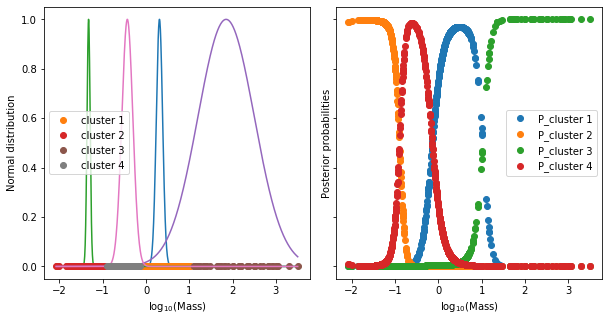

In [48]:
#class_mass = classification(4, np.log10(CoM[["Center_of_Mass"]]),True)

### Function: Fraction changed
This function generates 1000 synthetic systems ( _Dawns_ ) per each data (the mass an its uncertainty). We take draws from this, and stimate the validation of the classification.

The posteriror probabilities are determinated by the function `gmm.predict()`

In [180]:
def fraction_changed(data, dawns):
    
    p_system    = data.groupby("star_name")
    system_list = list(p_system.groups.keys())
    draws       = [] #draws of COM for each system. 
    
    for i in range(len(system_list)):
        
        system_i      = data[data.star_name == system_list[i]]  
        system_i_mass = np.zeros(dawns)
        cm_i          = np.zeros(dawns) 
        
        for k in range(len(system_i)):
            masses = np.random.normal(system_i.mass.values[k],
                                      system_i.mass_error_min.values[k],
                                      dawns)
            axes = np.random.normal(system_i.semi_major_axis.values[k],
                                    system_i.semi_major_axis_error_min.values[k],
                                    dawns)
            cm_i          += masses*axes
            system_i_mass += masses
        #draws.append([np.abs(cm_i/system_i_mass)]
        draws.append([cm_i/system_i_mass])
    draws = np.array(draws)
    draws = draws[draws>0]
    return draws
        

In [183]:
frc = fraction_changed(data,1000)
len(frc)

986190

In [194]:
from scipy.stats import truncnorm
a=0.1
b=2
x = np.linspace(truncnorm.ppf(0.01, a, b), 
                truncnorm.ppf(0.99, a, b), 
                100)
#print(x)
#plt.plot(truncnorm.ppf(x,a,b),x)

#r = truncnorm.rvs(a, b, size=1000)
len(r)

1000

In [96]:
#list(p_system.groups.keys())

In [121]:
system_list = list(p_system.groups.keys())
len(system_list)

987

In [92]:
data[data.star_name == list(p_system.groups.keys())[i]]

,star_name,mass,mass_error_min,semi_major_axis,semi_major_axis_error_min
3821,ups And,0.620,0.090,0.0590,0.00100
3824,ups And,1.059,0.028,5.2456,0.00067


In [95]:
list(p_system.groups.keys())[1]

' TYC 4282-605-1'

In [ ]:
#'dawns' is the number of synthetic systems per each data known
#'data' is a DataFrame of the data, with column "Center of Mass"
#'n_components' is the number of clusters for the lowest BIC/AIC.

def fraction_changed(n_components, dawns, data, log=False):
    
    draws=[]

    #1000 draws per planetary mass or systrem mass
    
    for i in range(len(data.values)):
        masses=np.random.normal(data.mass.values[i],
                                data.mass_error_min.values[i],
                                dawns)
        masses = masses[masses>0]
        draws += [masses]

    if log==True:
        mass = np.log10(data[["mass"]])
        draws = [np.log10(i) for i in draws]
        
    else:
        mass = data[["mass"]]
     
    #Gausian mixture model for masses  data:  
    gmm = GaussianMixture(n_components,covariance_type='full',random_state=0)
    gmm.fit(mass.values)
    cluster_label = gmm.predict(mass.values)
         
    #fraction of the synthttic systems wich change classification group:
    fraction_changed = []
    
    #to get only the posotice values of the draws, just get tyhe positives values: 
    #draws = [i for i in draws if i > 0] or None
    
    for index in range(len(draws)):
        #draw_i=np.abs(draws[index][:,np.newaxis])
        draw_i=draws[index][:,np.newaxis]
        orig=gmm.predict(np.array(mass))[index]
        fraction_changed+=[(orig!=gmm.predict(draw_i)).sum()/1000]
    lid=[len(i) for i in draws]
    #print( np.min(lid),np.mean(lid) )
    return(draws)
    #return((np.array(fraction_changed)<=0.1).sum()/len(fraction_changed))
    #return fraction_changed

In [ ]:
frac_mass=fraction_changed(4,1000,CoM[["Center_of_Mass"]],False)

In [ ]:
#np.log10(data[["Center_of_Mass"]])==np.log10(CoM[["Center_of_Mass"]])

In [ ]:
#GaussianMixture:  a firs approximation for 10 grups
#----------------------------------------------------------------------
data = CoM
gmm = GaussianMixture(10, covariance_type='full', random_state=0)
CM=CoM[["Center_of_Mass"]]
gmm.fit(CM.values)
cluster_label = gmm.predict(CM.values)
plt.scatter((CM.values),np.zeros(len(CM)), c=cluster_label);
plt.ylim(-0.1,0.1)
plt.xlabel(r"Center Of Mass (AU)", fontsize="15")
#For the CoM is nessesary emply a Logarithm sclae.

In [ ]:
#the log10scale for center of mass of each exoplanetary system:
#----------------------------------------------------------------------
CM_log=np.log10(data[["Center_of_Mass"]])

GMM,cluster=[],[]

#Some different components for Gaussian Mixture Model: 
#----------------------------------------------------------------------
for i in [2,3]:
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    GMM.append(gmm)
    gmm.fit(CM_log.values)
    cluster_label = gmm.predict(CM_log.values)
    cluster.append(cluster_label)

# (just a plot for two grups)
#----------------------------------------------------------------------
#plt.rc('text', usetex=True)

color=[]
#len(cluster[0])
for i in range(len(cluster[0])):
    if cluster[0][i] == 0:
        color.append("C1")
    elif cluster[0][i] == 1:
        color.append("C2")

x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig, ax1 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.15,right=0.96, left=0.115, top=0.93)

for i, (v1,v2) in enumerate(zip(GMM[0].means_,GMM[0].covariances_)):
    ax1.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    ax1.legend(fontsize=15,edgecolor='black')

ax1.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  

ax1.tick_params(labelsize=19)

plt.title(r"GMM with two components",fontsize=19)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=20)
plt.ylabel(r'Normal Distribution',fontsize=20)
#plt.savefig("figures/GMM2.pdf")

In [ ]:
# (just a plot for five grups)
#----------------------------------------------------------------------
color=[]
C = cluster[1]
for i in range(len(cluster[1])):
    if C[i] == 0:
        color.append("C1")
    elif C[i] == 1:
        color.append("C2")
    elif C[i] == 2:
        color.append("C3")
    elif C[i] == 3:
        color.append("C4")
    elif C[i] == 4:
        color.append("C5")

x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig2, ax2 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.17,right=0.97, left=0.175, top=0.90)

for i, (v1,v2) in enumerate(zip(GMM[1].means_,GMM[1].covariances_)):
    ax2.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    ax2.legend(fontsize=14, loc=1,edgecolor='black')

ax2.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  
ax2.set_xlim(-2.3,5.2)

ax2.tick_params(labelsize=19)

plt.title(r"GMM with three components",fontsize=22)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=20)
plt.ylabel(r'Normal Distribution',fontsize=20)
#plt.savefig("figures/GMM3.pdf")

In [ ]:
col=[]
#len(cluster[0])
for i in range(len(cluster[0])):
    if cluster[0][i] == 0:
        col.append("C1")
    elif cluster[0][i] == 1:
        col.append("C2")

lor=[]
C = cluster[1]
for i in range(len(cluster[1])):
    if C[i] == 0:
        lor.append("C1")
    elif C[i] == 1:
        lor.append("C2")
    elif C[i] == 2:
        lor.append("C3")
    elif C[i] == 3:
        lor.append("C4")
    elif C[i] == 4:
        lor.append("C5")        
        
x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig, axs = plt.subplots(1, 2, figsize=(13.5, 6.1), sharey=True)

plt.gcf().subplots_adjust(bottom=0.12,right=0.99, left=0.07, top=0.88)

axs[0].scatter((CM_log.values),np.zeros(len(CM_log)),c=col)  
axs[1].scatter((CM_log.values),np.zeros(len(CM_log)),c=lor)  

for i, (v1,v2) in enumerate(zip(GMM[0].means_,GMM[0].covariances_)):
    axs[0].plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    axs[0].legend(fontsize=18,edgecolor='black',bbox_to_anchor=(-0, 1.02, 1, .15), loc=3,
           ncol=2,mode="expand")

for i, (v1,v2) in enumerate(zip(GMM[1].means_,GMM[1].covariances_)):
    axs[1].plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    axs[1].legend(fontsize=18,edgecolor='black',bbox_to_anchor=(0, 1.02, 1, .102), loc=3,
           ncol=3, mode="expand")
    
axs[0].set_ylim(-0.1,1.1,1/10)

axs[0].tick_params(labelsize=19)
axs[1].tick_params(labelsize=19)
plt.subplots_adjust(wspace=0.04)

#axs.xlabel(r'$\log_{10}$(CM)',fontsize=20)
axs[0].set_ylabel(r'Normal Distribution',fontsize=22)
fig.text(0.53, 0.025, r"$\log_{10}$(CM)", fontsize=22, ha='center', va='center')

#plt.savefig("figures/GMM2-4.pdf")

To determine the number of cluster in the Gaussian Mixture Model, it may use a bayessian information criterion

In [ ]:
#Bayesian information criterion 
bic=[]
for i in range(10):
    i+=1
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    CM_log=np.log10(data[["Center_of_Mass"]])
    gmm.fit(CM_log.values)
    bic+=[gmm.bic(CM_log.values)]
#bic

In [ ]:
min(bic)

In [ ]:
# (just a plot to bayessian criterion)
#----------------------------------------------------------------------

#fig = plt.figure(figsize=(4,3))
#plt.plot(range(1,11),bic)

fig3, ax3 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.19,right=0.98, left=0.18, top=0.95)

f = ax3.plot(range(1,11),bic/max(bic), "o", c="C1",label="BIC values")
h = ax3.plot(range(1,11),bic/max(bic), lw="2")
g = ax3.plot(range(1,11),np.ones(len(bic))*min(bic)/max(bic),"--")

ax3.set_xlim(0.5,10.5)
ax3.tick_params(labelsize=18)
ax3.legend(fontsize=16, loc=1,edgecolor='black')

ax3.set_yticks(range(0,1),1/10)

#plt.title(r"Bayessian Information Criterion",fontsize=16)
plt.xlabel(r'Number of Clusters',fontsize=20)
plt.ylabel(r'Normalized BIC',fontsize=20)
#plt.savefig("figures/BIC.pdf")

In [ ]:
# GaussianMixture, for the log of CM: 
# 4 groups due tu the bic
gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM_log=np.log10(data[["Center_of_Mass"]])
gmm.fit(CM_log.values)
cluster_label = gmm.predict(CM_log.values)
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);
plt.ylim(-0.1,1)

The probabilities or verisimilitudes, are defined by normal distribution for each group from the gaussian mixture model:

In [ ]:
#gmm.means_
#just a plot to bayessian criterion for 4 clusters 
#----------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.gcf().subplots_adjust(bottom=0.15,right=0.96, left=0.08, top=0.93)

color=[]
CL = cluster_label
for i in range(len(cluster[1])):
    if CL[i] == 0:
        color.append("C1")
    elif CL[i] == 1:
        color.append("C2")
    elif CL[i] == 2:
        color.append("C3")
    elif CL[i] == 3:
        color.append("C4")
    elif CL[i] == 4:
        color.append("C5")
        
colors=["C1","C2","C3","C4","C5"]

#fig4, ax4 = plt.subplots(1, 1, sharex='col', sharey='row')

for i, (v1,v2) in enumerate(zip(gmm.means_,gmm.covariances_)):
    plt.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1),lw=2)
    plt.legend(fontsize=24, loc=1,edgecolor='black')

plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  
plt.xlim(-2.2,3.7)

plt.tick_params(labelsize=24)

plt.title(r"GMM for the BIC clusters",fontsize=25)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=26)
plt.ylabel(r'Normal Distribution',fontsize=26)
#plt.savefig("figures/GMM4.pdf") 

The posteriror probabilities are determinated by the function `gmm.predict_proba()`

In [ ]:
# The posterior probabilities: 
names=["Earth-centered", "Close","Far away","Venusian-centered"]
plt.figure(figsize=(7,5.6))

for i in range(4):
    plt.scatter(CM_log,gmm.predict_proba(CM_log)[:,i],label=names[i]);

plt.gcf().subplots_adjust(bottom=0.15,right=0.97, left=0.15, top=0.83)
plt.tick_params(labelsize=20)    
plt.xlabel(r'$\log_{10}$(CM)',fontsize=22)
plt.ylabel(r'Posterior Probabilities',fontsize=22)
plt.xlim(-2.5,4)
plt.legend(fontsize=17.5,edgecolor='black', 
           bbox_to_anchor=(-0.02, 1.20, 1.037, 0.06), loc=2,
           ncol=2, mode="expand")
#plt.savefig("figures/Prob.pdf")

The probability for a synthetic draw of a system called AA, with a $\mu=0.8$ and $\sigma=0.03$ in the CM, can be established as:

In [ ]:
AA=np.log10(np.random.normal(0.8,0.03,1000))
AA=AA[:,np.newaxis]
names=["Earth-centered", "Close","Far away","Venusian-centered"]
plt.figure(figsize=(7,5.6))

#production of probability for a syntethic planetary system 
for i in range(4):
    plt.scatter(AA,gmm.predict_proba(AA)[:,i],label=names[i])

plt.gcf().subplots_adjust(bottom=0.15,right=0.965, left=0.14, top=0.83)
plt.legend(fontsize=17.5,edgecolor='black', 
           bbox_to_anchor=(-0.02, 1.20, 1.037, 0.055), loc=2,
           ncol=2, mode="expand")
plt.tick_params(labelsize=20)    
plt.xlabel(r'$\log_{10}$(CM)',fontsize=22)
plt.ylabel(r'Probability',fontsize=22)
#plt.savefig("figures/draw.pdf")

## ... Draws
Employing m and $\Delta$m, a and $\Delta$a, from `data2`.

In [ ]:
# Group the planetary system:
data2 = dataB[['star_name','mass', 'mass_error_min',
               'semi_major_axis','semi_major_axis_error_min']]
Planetary_System = data2.groupby("star_name")
Systems_List = list(Planetary_System.groups.keys())

A first way to get the drows for each system:

In [ ]:
#%%time
#-------------------------------------------------------------------------
# Draws, for each planetary system
draws=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    system_i = data2[data2.star_name == Systems_List[i]]    
    draw_i=[]
    for j in  range(1000):
        #Get random values for each planet in a system and the COM for those values
        masses=np.random.normal(system_i.mass,system_i.mass_error_min)
        axes=np.random.normal(system_i.semi_major_axis,
                              system_i.semi_major_axis_error_min)
        draw_i += [(masses*axes).sum()/masses.sum()]
    draws.append(draw_i)


In [ ]:
#len(draws[0])

Second way to get the draws for each system (in a shorter time):

In [ ]:
#%%time
DrawsA=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    SystemA_i = data2[data2.star_name == Systems_List[i]]  
    Mass_System = np.zeros(1000)
    Mass_Axe = np.zeros(1000) 
    for k in range(len(SystemA_i)):
        Masses = np.random.normal(SystemA_i.mass.values[k],
                                  SystemA_i.mass_error_min.values[k],1000)
        Axes = np.random.normal(SystemA_i.semi_major_axis.values[k],
                                SystemA_i.semi_major_axis_error_min.values[k],
                                1000)
        Mass_Axe += Masses*Axes
        Mass_System += Masses
        #print(SystemA_i.mass.values[k])
    DrawsA.append([np.abs(Mass_Axe/Mass_System)])
len(DrawsA)

In [ ]:
SystemA_i = data2[data2.star_name == Systems_List[2]]  
SystemA_i
#type(DrawsA[2][0])#[987)

In [ ]:
plt.hist(np.random.normal(3.9,1.7,1000))

In [ ]:
#import seaborn as sns
#sns.set()
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

f1 = ax1.hist(DrawsA[2][0],10,alpha=0.8,label=Systems_List[2]+" DrawsA")
f2 = ax1.hist(draws[2],10, alpha=0.6,label=Systems_List[2]+" draws")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)
f2 = sns.kdeplot(DrawsA[2][0], shade=True,label=Systems_List[2]+" DrawsA")
f3 = sns.kdeplot(draws[2], shade=True,label=Systems_List[2]+" draws")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

The probability of each draw to belong a each group, taking draws form `DrawsA`

In [ ]:
kk=8
Draw_i=np.log10(DrawsA[kk][0][:,np.newaxis])
orig=gmm.predict(np.array(CM_log))[kk]
print(orig)
print((orig!=gmm.predict(Draw_i)).sum()/1000)
for i in range(4):
    plt.scatter(Draw_i,gmm.predict_proba(Draw_i)[:,i])

In [ ]:
np.log10(DrawsA[8])[0][:10]

In [ ]:
plt.hist(np.log10(DrawsA[8])[0])

In [ ]:
# CM_log is the centero of mass in log scale for each system
frac=[]
for kk in range(len(DrawsA)):
    Draw_i=np.log10(DrawsA[kk][0][:,np.newaxis])
    orig=gmm.predict(np.array(CM_log))[kk]
#    print(kk)
    frac+=[(orig!=gmm.predict(Draw_i)).sum()/1000] # AA es el elemento i de draws (que debe ser un array de 1000 elementos)


#for i in range(4):
#    plt.scatter(Draw_i,gmm.predict_proba(Draw_i)[:,i])
#orig
#AA
#orig=gmm.predict(np.array([[0.8]])) # 0.8 es el centro de masa para el sistema i
#(orig!=gmm.predict(AA)).sum()/1000 # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
#DrawsA[0]
#Draw_i=DrawsA[0][0][:,np.newaxis]
#gmm.predict(Draw_i)
#Draw_i
#gmm.predict(Draw_i)
plt.hist(frac)
print((np.array(frac)==0).sum()/len(frac))
np.max(frac)

In [ ]:
orig=gmm.predict(np.array(CM_log))[2]
print(CM_log.values)
DrawsA[2][0]

#### Metallicity

In [ ]:
dataMet = data_ep[pd.notnull(data_ep["star_metallicity"])]
dataMetA = dataMet[pd.notnull(dataMet["star_metallicity_error_min"])]
dataMet = dataMetA[['star_name',"star_metallicity","star_metallicity_error_min"]]

In [ ]:
gmm2 = GaussianMixture(3, covariance_type='full', random_state=0)
B=dataMet[["star_metallicity"]]
gmm2.fit(B.values)
cluster_label = gmm2.predict(B.values)
B.values[:, 0]
plt.scatter((B.values),np.zeros(len(B)), c=cluster_label);
plt.ylim(-0.1,1)

In [ ]:
bic=[]
for i in range(15):
    i+=1
    gmm2 = GaussianMixture(i, covariance_type='full', random_state=0)
    A=data1[["center_of_Mass"]]
    gmm2.fit(B.values)
    bic+=[gmm2.bic(B.values)]
plt.plot(range(1,16),bic)

In [ ]:
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
plt.scatter((A.values),np.zeros(len(A)), c = cluster_label);